In [318]:
from pandas.io.json import json_normalize
from elasticsearch import helpers, Elasticsearch
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [319]:
initial_ts = "2020-07-26T00:25:01.000Z"

In [320]:
es= Elasticsearch(["10.184.97.138","10.184.97.139","10.184.97.140"],
                 http_auth=("elastic","root123"),
                 port=9200,
                 use_ssl=True,
                 verify_certs=False)

C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\elasticsearch\connection\http_urllib3.py:206: UserWarning: Connecting to https://10.184.97.138:9200 using SSL with verify_certs=False is insecure.
  % self.host
C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\elasticsearch\connection\http_urllib3.py:206: UserWarning: Connecting to https://10.184.97.139:9200 using SSL with verify_certs=False is insecure.
  % self.host
C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\elasticsearch\connection\http_urllib3.py:206: UserWarning: Connecting to https://10.184.97.140:9200 using SSL with verify_certs=False is insecure.
  % self.host


In [321]:
es.info()

C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\urllib3\connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.184.97.140'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
INFO:elasticsearch:GET https://10.184.97.140:9200/ [status:200 request:0.321s]


{'name': 'dev-node-3',
 'cluster_name': 'lab_development_cluster',
 'cluster_uuid': 'jQ2xplAlTEOuI6P-22P6nA',
 'version': {'number': '7.9.1',
  'build_flavor': 'default',
  'build_type': 'rpm',
  'build_hash': '083627f112ba94dffc1232e8b42b73492789ef91',
  'build_date': '2020-09-01T21:22:21.964974Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [322]:
def fetch_data_from_elasticsearch(timestamp):
    
    res = es.search(index="optus_maip_data_usage_dummy",body={ "query": {
        "range": {
          "@timestamp": {
            "gt": timestamp

          }
        }
      },
      "_source": ["DataUsage","RatePlanId","@timestamp"] ,
      "sort": [
        {
          "@timestamp": {
            "order": "asc"
          }
        }
      ],"size":10000})
    
    if res["hits"]["total"]['value'] > 0:
        data=res["hits"]["hits"][:]
        df_json = json_normalize(data)
        df = df_json[["_source.@timestamp","_source.DataUsage","_source.RatePlanId"]]
        df.columns = ["date","dataUsage","rateplanid"]        
        more_data = "Y"
        
    else:
        df = pd.DataFrame()
        more_data = "N"
            
    return df, more_data
        

In [323]:
def load_data(timestamp):
    df = pd.DataFrame()
    data, more_data = fetch_data_from_elasticsearch(initial_ts)
    df = df.append(data)    
    
    while more_data == "Y":
        ts = data.iloc[-1,0]  
        data, more_data = fetch_data_from_elasticsearch(ts)    
        if more_data == "Y":
            df = df.append(data)            
 
    return df
    

In [324]:
df = load_data(initial_ts)      
df = df.reset_index()
df = df.drop(['index'], axis = 1)
    

C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\urllib3\connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.184.97.138'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
INFO:elasticsearch:POST https://10.184.97.138:9200/optus_maip_data_usage_dummy/_search [status:200 request:1.646s]
C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\urllib3\connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.184.97.139'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
INFO:elasticsearch:POST https://10.184.97.139:9200/optus_maip_data_usage_dummy/_search [status:200 request:1.533s]
C:\Users\evkikum\AppData\Local\Continuum\Anaco

In [325]:
df.head()

,date,dataUsage,rateplanid
0,2020-07-26T00:30:20.000Z,0,2111
1,2020-07-26T00:33:33.000Z,77432725,2111
2,2020-07-26T00:35:10.000Z,8165205,1038
3,2020-07-26T00:37:59.000Z,135295,2102
4,2020-07-26T00:40:32.000Z,1209119,2112


In [326]:
df.count()

date          29992
dataUsage     29992
rateplanid    29992
dtype: int64

In [327]:
df = df.drop(['rateplanid'], axis=1)

In [328]:
df.head()

,date,dataUsage
0,2020-07-26T00:30:20.000Z,0
1,2020-07-26T00:33:33.000Z,77432725
2,2020-07-26T00:35:10.000Z,8165205
3,2020-07-26T00:37:59.000Z,135295
4,2020-07-26T00:40:32.000Z,1209119


In [329]:
df.columns = ['ds','y']

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29992 entries, 0 to 29991
Data columns (total 2 columns):
ds    29992 non-null object
y     29992 non-null object
dtypes: object(2)
memory usage: 468.7+ KB


In [331]:
df['ds'] = pd.to_datetime(df['ds'])

In [332]:
df.head()

,ds,y
0,2020-07-26 00:30:20,0
1,2020-07-26 00:33:33,77432725
2,2020-07-26 00:35:10,8165205
3,2020-07-26 00:37:59,135295
4,2020-07-26 00:40:32,1209119


In [333]:
df.tail()

,ds,y
29987,2020-09-25 23:54:45,0
29988,2020-09-26 00:01:41,0
29989,2020-09-26 00:05:28,135295
29990,2020-09-26 00:12:05,0
29991,2020-09-26 00:17:39,708284


In [334]:
df.isnull().sum()

ds    0
y     0
dtype: int64

In [335]:
##df['y'] = pd.to_numeric(df['y'])
df['y'] = df['y'].convert_objects(convert_numeric=True)

C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29992 entries, 0 to 29991
Data columns (total 2 columns):
ds    29992 non-null datetime64[ns]
y     29992 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 468.7 KB


In [337]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\evkikum\AppData\Local\Continuum\Anaconda3\envs\tsa_course\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


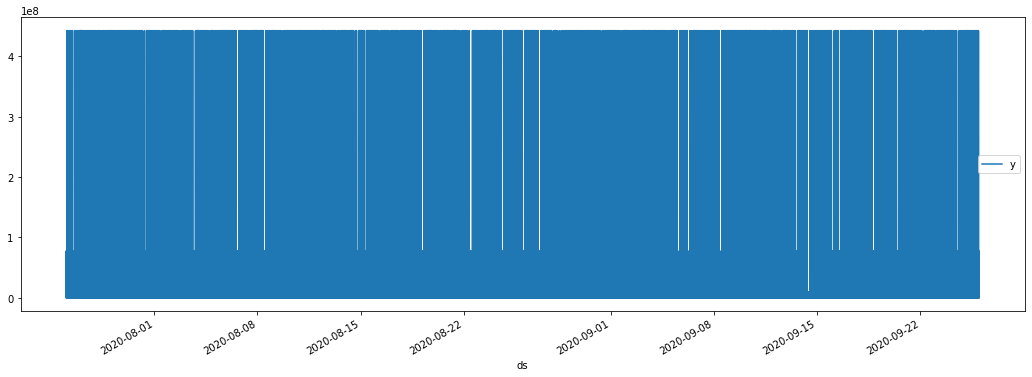

In [338]:
df.plot(x='ds',y='y',figsize=(18,6))

In [339]:
future = m.make_future_dataframe(periods=86400,freq='min')

In [340]:
future

,ds
0,2020-07-26 00:30:20
1,2020-07-26 00:33:33
2,2020-07-26 00:35:10
3,2020-07-26 00:37:59
4,2020-07-26 00:40:32
5,2020-07-26 00:42:58
6,2020-07-26 00:43:19
7,2020-07-26 00:44:17
8,2020-07-26 00:46:52
9,2020-07-26 00:50:51


In [341]:
forecast = m.predict(future)


In [342]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-26 00:30:20,3.182600e+07,-1.023942e+08,1.614332e+08,3.182600e+07,3.182600e+07,444695.559696,444695.559696,444695.559696,1.265781e+06,1.265781e+06,1.265781e+06,-821085.656047,-821085.656047,-821085.656047,0.0,0.0,0.0,3.227070e+07
1,2020-07-26 00:33:33,3.182609e+07,-9.615969e+07,1.731902e+08,3.182609e+07,3.182609e+07,383150.231282,383150.231282,383150.231282,1.202299e+06,1.202299e+06,1.202299e+06,-819149.217264,-819149.217264,-819149.217264,0.0,0.0,0.0,3.220924e+07
2,2020-07-26 00:35:10,3.182614e+07,-1.043711e+08,1.741331e+08,3.182614e+07,3.182614e+07,352370.751991,352370.751991,352370.751991,1.170544e+06,1.170544e+06,1.170544e+06,-818172.970291,-818172.970291,-818172.970291,0.0,0.0,0.0,3.217851e+07
3,2020-07-26 00:37:59,3.182621e+07,-1.079419e+08,1.696342e+08,3.182621e+07,3.182621e+07,299056.500213,299056.500213,299056.500213,1.115524e+06,1.115524e+06,1.115524e+06,-816467.290513,-816467.290513,-816467.290513,0.0,0.0,0.0,3.212527e+07
4,2020-07-26 00:40:32,3.182628e+07,-1.111891e+08,1.735359e+08,3.182628e+07,3.182628e+07,251198.905296,251198.905296,251198.905296,1.066117e+06,1.066117e+06,1.066117e+06,-814917.855249,-814917.855249,-814917.855249,0.0,0.0,0.0,3.207748e+07


In [343]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [344]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
116380,2020-11-25 00:06:39,4.214039e+07,-9.456022e+07,1.824206e+08
116381,2020-11-25 00:07:39,4.212416e+07,-9.804842e+07,1.736118e+08
116382,2020-11-25 00:08:39,4.210787e+07,-8.958092e+07,1.762384e+08
116383,2020-11-25 00:09:39,4.209151e+07,-9.062797e+07,1.813989e+08
116384,2020-11-25 00:10:39,4.207509e+07,-8.674388e+07,1.850076e+08
116385,2020-11-25 00:11:39,4.205861e+07,-1.041647e+08,1.826955e+08
116386,2020-11-25 00:12:39,4.204207e+07,-8.780176e+07,1.632801e+08
116387,2020-11-25 00:13:39,4.202549e+07,-1.025746e+08,1.800553e+08
116388,2020-11-25 00:14:39,4.200886e+07,-9.494557e+07,1.683749e+08
116389,2020-11-25 00:15:39,4.199219e+07,-9.164263e+07,1.854139e+08


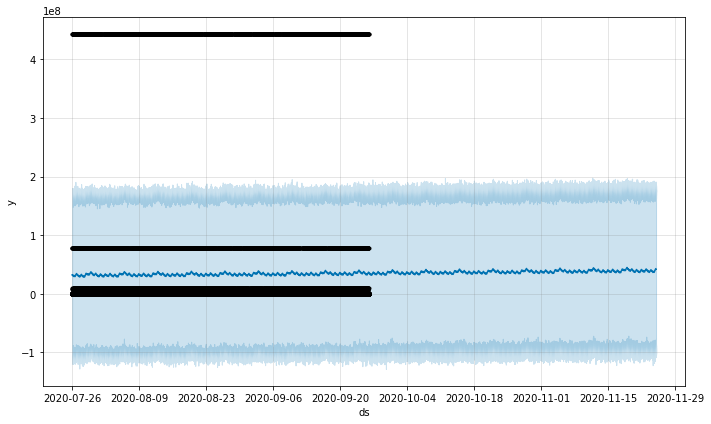

In [347]:
m.plot(forecast);

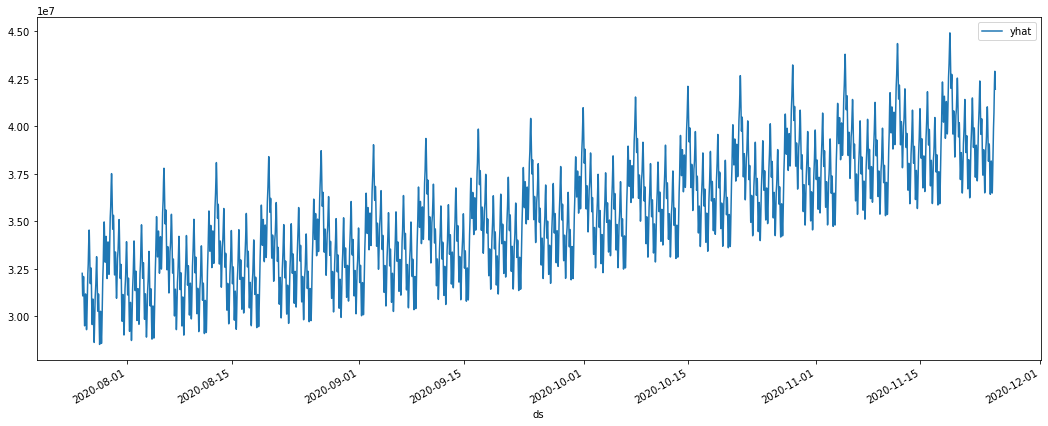

In [352]:
forecast.plot(x='ds',y='yhat', figsize=(18,7))

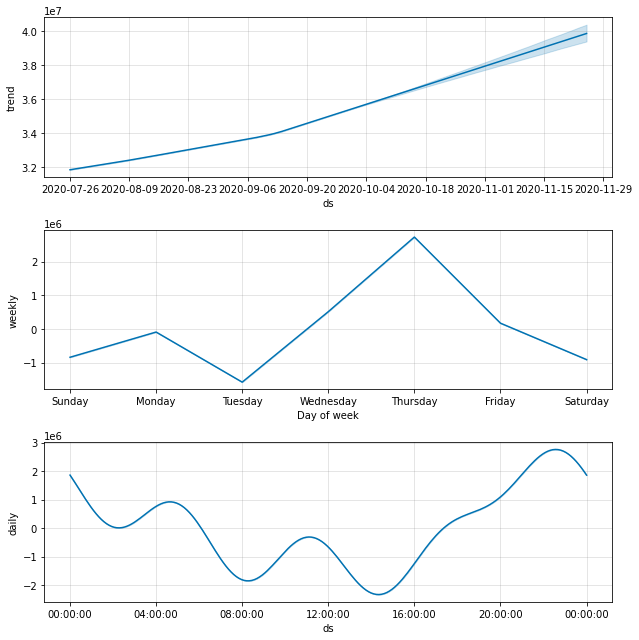

In [348]:
m.plot_components(forecast);